In [1]:
import pandas as pd

In [2]:
data="""Rank Name Age Height
(cm)
Weight
(kg) Career Titles
1 Novak Djokovic 35 188 77 93
2 Carlos Alcaraz 19 183 74 7
3 Stefanos Tsitsipas 24 193 90 9
4 Casper Ruud 24 183 77 9
5 Andrey Rublev 25 188 75 12
6 Rafael Nadal 36 185 85 92
7 Taylor Fritz 25 196 86 5
8 Daniil Medvedev 27 198 83 16
9 Felix Auger-Aliassime 22 193 88 4
10 Holger Rune 19 188 77 3"""
data = data.splitlines()
data = [" ".join(data[:4])] + data[4:]
columns = data[0].split()
columns = columns[0:3] + [" ".join(columns[3:5])] +[" ".join(columns[5:7])] + [" ".join(columns[7:])]
data = [i.split() for i in data[1:]]
data = [x[:1] + [" ".join(x[1:3])] + x[3:] for x in data]
# display(data, columns)
data = pd.DataFrame(data, columns=columns)
for col,dtype in zip(columns, [int, str, int, int, int, int]):
    data[col] = data[col].astype(dtype)

display(data.rename({col: f"{col} ({data[col].dtype})" for col in data.columns}, axis=1))

,Rank (int32),Name (object),Age (int32),Height (cm) (int32),Weight (kg) (int32),Career Titles (int32)
0,1,Novak Djokovic,35,188,77,93
1,2,Carlos Alcaraz,19,183,74,7
2,3,Stefanos Tsitsipas,24,193,90,9
3,4,Casper Ruud,24,183,77,9
4,5,Andrey Rublev,25,188,75,12
5,6,Rafael Nadal,36,185,85,92
6,7,Taylor Fritz,25,196,86,5
7,8,Daniil Medvedev,27,198,83,16
8,9,Felix Auger-Aliassime,22,193,88,4
9,10,Holger Rune,19,188,77,3


In [3]:
## (a)
# Low level implementation for better understanding
n_bins = 2
size_bins = len(data) // n_bins

# Take note that this looks like it creates a list of n_bins empty lists, 
# but it actually creates a list of n_bins references to the same empty list.
# bins =[[]]*n_bins
# Therefore this
bins = [[] for _ in range(n_bins)]
last_age, last_bin = 0, 0
for i, row in enumerate(data.sort_values("Age").itertuples()):
    if row.Age == last_age:
        bins[last_bin].append(row)
    else:
        bins[i//size_bins].append(row)
        last_age, last_bin = row.Age, i//size_bins

bin_bounds = [(bin[0].Age, bin[-1].Age) for bin in bins]
for bin, (lower, upper) in zip(bins, bin_bounds):
    print(f"Age range: {lower}-{upper}")
    for row in bin:
        print(f"{row.Rank} {row.Name} {row.Age}")
    print()

Age range: 19-24
2 Carlos Alcaraz 19
10 Holger Rune 19
9 Felix Auger-Aliassime 22
3 Stefanos Tsitsipas 24
4 Casper Ruud 24

Age range: 25-36
5 Andrey Rublev 25
7 Taylor Fritz 25
8 Daniil Medvedev 27
1 Novak Djokovic 35
6 Rafael Nadal 36



In [4]:
# Equal frequency binning making more use of libraries, feel free to experiment with the parameters
from sklearn.preprocessing import KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')

cell_df = data.copy()
cell_df['Age Bin'] = discretizer.fit_transform(cell_df[['Age']]).astype(int)

for bin in sorted(cell_df['Age Bin'].unique()):
    bin_df = cell_df[cell_df['Age Bin'] == bin]
    print(f"Bin {int(bin)+1}: [{bin_df['Age'].min()}, {bin_df['Age'].max()}] len={len(bin_df)}")
    display(bin_df.sort_values('Age'))

Bin 1: [19, 24] len=5


,Rank,Name,Age,Height (cm),Weight (kg),Career Titles,Age Bin
1,2,Carlos Alcaraz,19,183,74,7,0
9,10,Holger Rune,19,188,77,3,0
8,9,Felix Auger-Aliassime,22,193,88,4,0
2,3,Stefanos Tsitsipas,24,193,90,9,0
3,4,Casper Ruud,24,183,77,9,0


Bin 2: [25, 36] len=5


,Rank,Name,Age,Height (cm),Weight (kg),Career Titles,Age Bin
4,5,Andrey Rublev,25,188,75,12,1
6,7,Taylor Fritz,25,196,86,5,1
7,8,Daniil Medvedev,27,198,83,16,1
0,1,Novak Djokovic,35,188,77,93,1
5,6,Rafael Nadal,36,185,85,92,1


In [5]:
## (b)
# Min-Max scaling low level implementation

min_scale, max_scale = 1, 10
min_raw, max_raw = 3, 93

# min_raw       (max_raw-min_raw)     max_raw
#    |-----------------------------------|
# min_scale   (max_scale-min_scale)   max_scale

raw_to_scaled = lambda x: (x-min_raw)*(max_scale-min_scale)/(max_raw-min_raw) + min_scale
scaled_to_raw = lambda x: (x-min_scale)*(max_raw-min_raw)/(max_scale-min_scale) + min_raw

assignment = [93,7,9]
for x in assignment:
    print(f"{x} -> {raw_to_scaled(x)}")

93 -> 10.0
7 -> 1.4
9 -> 1.6


In [6]:
# Min-Max scaling using libraries
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(1, 10))
cell_df = data.copy()
col = 'Career Titles'
cell_df.insert(cell_df.columns.get_loc(col)+1, f"{col} Scaled", scaler.fit_transform(cell_df[[col]]))

if False:
    display(cell_df[cell_df["Rank"].apply(lambda x: x in [1,2,3])])
else:
    display(cell_df)

,Rank,Name,Age,Height (cm),Weight (kg),Career Titles,Career Titles Scaled
0,1,Novak Djokovic,35,188,77,93,10.0
1,2,Carlos Alcaraz,19,183,74,7,1.4
2,3,Stefanos Tsitsipas,24,193,90,9,1.6
3,4,Casper Ruud,24,183,77,9,1.6
4,5,Andrey Rublev,25,188,75,12,1.9
5,6,Rafael Nadal,36,185,85,92,9.9
6,7,Taylor Fritz,25,196,86,5,1.2
7,8,Daniil Medvedev,27,198,83,16,2.3
8,9,Felix Auger-Aliassime,22,193,88,4,1.1
9,10,Holger Rune,19,188,77,3,1.0


In [7]:
## (c) Outliers
from sklearn.preprocessing import StandardScaler
import re
df_c = data.copy()
scaler_c = StandardScaler()
numeric_columns = ['Age', 'Height (cm)', 'Weight (kg)', 'Career Titles']
scaler_c.fit(df_c[numeric_columns]);
df_c[numeric_columns] = scaler_c.transform(df_c[numeric_columns])
for col in df_c.columns:
    df_c[col] = df_c[col].round(2)
    name = col
    if match:=re.search(r"\s*\(.*\)\s*$", name):
        name = name[:match.start()]
    name = name.replace(" ", "_").lower()
    df_c.rename({col: name}, axis=1, inplace=True)
display(df_c)


,rank,name,age,height,weight,career_titles
0,1,Novak Djokovic,1.70,-0.3,-0.76,2.00
1,2,Carlos Alcaraz,-1.20,-1.3,-1.30,-0.53
2,3,Stefanos Tsitsipas,-0.29,0.7,1.59,-0.47
3,4,Casper Ruud,-0.29,-1.3,-0.76,-0.47
4,5,Andrey Rublev,-0.11,-0.3,-1.12,-0.38
5,6,Rafael Nadal,1.88,-0.9,0.69,1.97
6,7,Taylor Fritz,-0.11,1.3,0.87,-0.59
7,8,Daniil Medvedev,0.25,1.7,0.32,-0.27
8,9,Felix Auger-Aliassime,-0.65,0.7,1.23,-0.62
9,10,Holger Rune,-1.20,-0.3,-0.76,-0.65


In [8]:
# Low level implementation
abs_error_threshold = 0.3
prediction_f = lambda x: (0.92*x.age) - (0.24 * x.height) - (0.02 * x.weight)
id_by_rank = [1,2,3]
cell_data = [row for row in df_c.itertuples() if row.rank in id_by_rank]
for row in cell_data:
    prediction = prediction_f(row)
    error = abs(row.career_titles - prediction)
    print(f"Rank {row.rank}:")
    print(f"\t{row.name} has a predicted career titles of {prediction:.2f} vs actual {row.career_titles:.2f}.")
    print(f"\tError: {error:.2f} {'(outlier)' if error > abs_error_threshold else ''}")


Rank 1:
	Novak Djokovic has a predicted career titles of 1.65 vs actual 2.00.
	Error: 0.35 (outlier)
Rank 2:
	Carlos Alcaraz has a predicted career titles of -0.77 vs actual -0.53.
	Error: 0.24 
Rank 3:
	Stefanos Tsitsipas has a predicted career titles of -0.47 vs actual -0.47.
	Error: 0.00 


career_titles = 0.92*age - 0.24*height - 0.02*weight  + 0.00


,rank,name,age,height,weight,career_titles,predicted_career_titles,predicted_career_titles_reversed,error,outlier
0,1,Novak Djokovic,1.70,-0.3,-0.76,2.00,1.65,35,0.35,True
1,2,Carlos Alcaraz,-1.20,-1.3,-1.30,-0.53,-0.77,19,0.24,False
2,3,Stefanos Tsitsipas,-0.29,0.7,1.59,-0.47,-0.46,24,0.01,False
3,4,Casper Ruud,-0.29,-1.3,-0.76,-0.47,0.06,24,0.53,True
4,5,Andrey Rublev,-0.11,-0.3,-1.12,-0.38,-0.01,25,0.37,True
5,6,Rafael Nadal,1.88,-0.9,0.69,1.97,1.94,36,0.03,False
6,7,Taylor Fritz,-0.11,1.3,0.87,-0.59,-0.43,25,0.16,False
7,8,Daniil Medvedev,0.25,1.7,0.32,-0.27,-0.18,27,0.09,False
8,9,Felix Auger-Aliassime,-0.65,0.7,1.23,-0.62,-0.79,22,0.17,False
9,10,Holger Rune,-1.20,-0.3,-0.76,-0.65,-1.02,19,0.37,True


<Axes: xlabel='rank', ylabel='career_titles'>

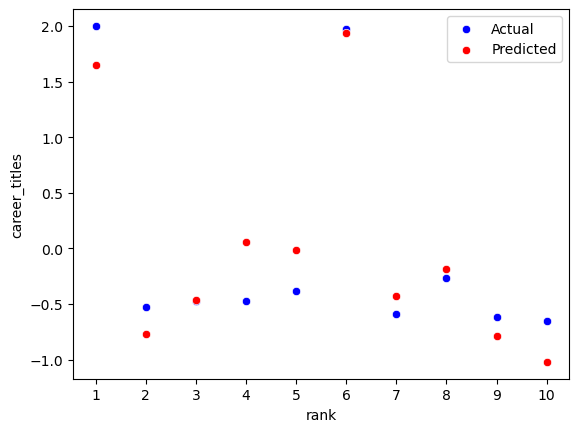

In [9]:
# High level implementation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns

cell_df = df_c.copy()
abs_error_threshold = 0.3
model = LinearRegression()
input_cells = ['age', 'height', 'weight']
target_cell = 'career_titles'
X = cell_df[input_cells]
y = cell_df[target_cell]
model.fit(X, y)
predictions = model.predict(X)
errors = np.abs(predictions - y)
cell_df[f'predicted_{target_cell}'] = predictions
cell_df[f'predicted_{target_cell}_reversed'] = (
    scaler_c.inverse_transform(cell_df[input_cells + [f'predicted_{target_cell}']]).T[0].T.round(0)
)
cell_df[f'predicted_{target_cell}_reversed'] = cell_df[f'predicted_{target_cell}_reversed'].astype(int)
cell_df['error'] = errors
cell_df['outlier'] = errors > abs_error_threshold

out_str = [f"{target_cell} ="]
for var,factor in zip(input_cells,model.coef_):
    if factor > 0:
        if len(out_str) > 2:
            out_str.append("+")
    else:
        out_str.append("-")
        factor = -factor
    out_str.append(f"{factor:.2f}*{var}")
out_str.append(f" + {model.intercept_:.2f}")
print(" ".join(out_str))
display(cell_df.round(2))

cell_df['rank'] = cell_df['rank'].astype(str)
sns.scatterplot(data=cell_df, x='rank', y=target_cell, color='blue', label='Actual')
sns.scatterplot(data=cell_df, x='rank', y=f'predicted_{target_cell}', color='red', label='Predicted')